# 长期价值投资数据监测

In [14]:
#imports

import yfinance as yf
import pandas as pd
import datetime as dt
import seaborn as sns
from  matplotlib import pyplot as plt

#init
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, 
            rc={'figure.figsize':(15,10)})
#pd.options.display.float_format = '{:,.2f}'.format

#parameters
ticker_list=['FB','MSFT','AAPL','GOOG','AMZN','BABA',
'NVDA','0700.HK','ADBE','MO','ADSK','ASML','BRK-B',
'GS','ISRG','KO','LVMUY','2318.HK','TSM','ADBE','MCO','1810.HK',
'3690.HK'

]



In [15]:
print('This notebook was refreshed at %s'%(dt.datetime.now()))

This notebook was refreshed at 2022-01-08 19:07:29.078118


## 美国国债收益率监测

In [16]:
df_rate=pd.DataFrame()
data=yf.download(['^IRX','^FVX','^TNX','^TYX'],progress=False)

df_rate=data.loc[dt.date.today()-dt.timedelta(days=365*10):]['Close']
df_rate.columns=['5 Years','13 Weeks','10 Years','30 Years']

In [17]:
s=df_rate.tail(1).style.format('{:.3f}%')
s

,5 Years,13 Weeks,10 Years,30 Years
Date,,,,
2022-01-07 00:00:00,1.505%,0.088%,1.771%,2.118%


Text(0.5, 1.0, '10 years trend of treasury yield')

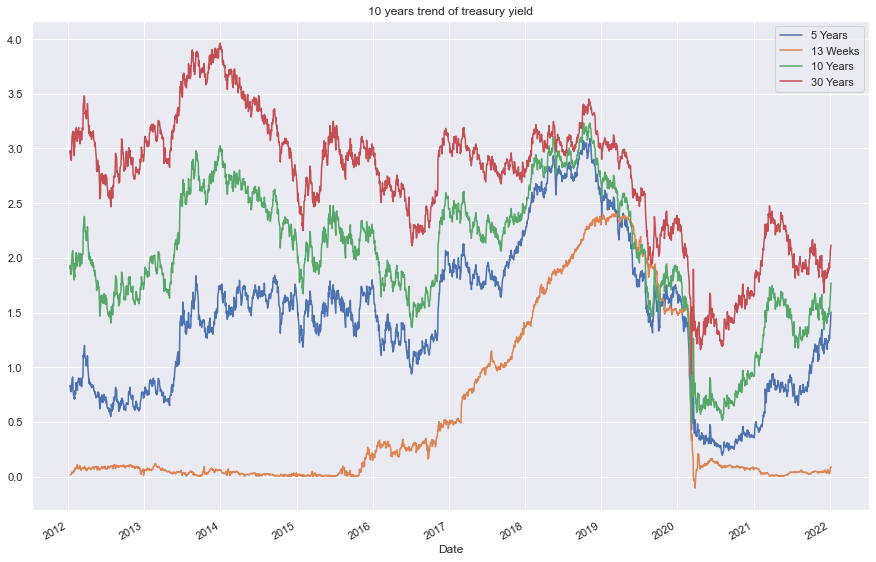

In [18]:
df_rate.plot()
plt.title("10 years trend of treasury yield")

## 股市和国债利率的相关度

## 跟踪公司数据监控

In [19]:

ticker_list=list(dict.fromkeys(ticker_list))

In [20]:
def get_stock_info(ticker):
    stock_info={}
    df=yf.download(ticker,start=dt.date.today()-dt.timedelta(days=366),auto_adjust=True,progress=True)
    stock_info=yf.Ticker(ticker).info
    stock_info['1w_chg_pct']=100*(df.loc[max(df.index)-dt.timedelta(weeks=1):,'Close'][-1]/df.loc[max(df.index)-dt.timedelta(weeks=1):,'Close'][0]-1)
    stock_info['1m_chg_pct']=100*(df.loc[max(df.index)-dt.timedelta(days=30):,'Close'][-1]/df.loc[max(df.index)-dt.timedelta(days=30):,'Close'][0]-1)
    stock_info['1y_chg_pct']=100*(df.loc[max(df.index)-dt.timedelta(days=365):,'Close'][-1]/df.loc[max(df.index)-dt.timedelta(days=365):,'Close'][0]-1)
    stock_info['max_drawdown']=100*(df.Close[-1]/max(df.Close)-1)
    stock_info['ticker']=ticker
    return stock_info


In [ ]:
df_stock=pd.DataFrame()
for ticker in ticker_list:
    try:
        stock_info=get_stock_info(ticker)
        df_stock=df_stock.append(stock_info,ignore_index=True)
    except:
        pass

df_stock['ratecode']=df_stock['financialCurrency']+'-'+df_stock['currency']
df_stock['ratecode']
df_stock['USD-USD']=1
df_stock['CNY-USD']=0.16
df_stock['TWD-USD']=0.036
df_stock['CNY-HKD']=1.22
df_stock['EUR-USD']=1.13
df_stock['rate']=df_stock['USD-USD'].where(df_stock['ratecode']=='USD-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['CNY-USD'].where(df_stock['ratecode']=='CNY-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['TWD-USD'].where(df_stock['ratecode']=='TWD-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['EUR-USD'].where(df_stock['ratecode']=='EUR-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['CNY-HKD'].where(df_stock['ratecode']=='CNY-HKD')
df_stock[['ticker','currency','financialCurrency','rate']]

In [22]:
df_vi_metric=pd.DataFrame()

df_vi_metric['ticker']=df_stock['ticker']
df_vi_metric['last_price']=df_stock['currentPrice']
df_vi_metric['target_price']=df_stock['targetMeanPrice']
df_vi_metric['drawdown_from_52w_peak']=100*(df_stock['currentPrice']/df_stock['fiftyTwoWeekHigh']-1)
df_vi_metric['1m_chg_pct']=df_stock['1m_chg_pct']
df_vi_metric['pcf']=df_stock['marketCap']/(df_stock['operatingCashflow']*df_stock['rate'])
df_vi_metric['pe_fwd']=df_stock['forwardPE']
df_vi_metric['pe_ttm']=df_stock['currentPrice']/df_stock['trailingEps']
df_vi_metric['revenue_growth']=df_stock['revenueGrowth']
df_vi_metric['cash_return_rate']=(df_stock['operatingCashflow']*df_stock['rate'])/df_stock['enterpriseValue']*100
df_vi_metric['roe']=df_stock['returnOnEquity']*100
df_vi_metric['gross_margin']=df_stock['grossMargins']*100
df_vi_metric['net_margin']=df_stock['profitMargins']*100
df_vi_metric['cf_margin']=df_stock['operatingCashflow']/df_stock['totalRevenue']*100
df_vi_metric['ps_ttm']=df_stock['priceToSalesTrailing12Months']
df_vi_metric['pb']=df_stock['priceToBook']
df_vi_metric=df_vi_metric.set_index('ticker')

In [38]:
df_vi_metric.reindex(columns=['last_price','target_price','drawdown_from_52w_peak','pcf','pe_ttm','pe_fwd','roe','revenue_growth','cash_return_rate','cf_margin']
).sort_values(by='drawdown_from_52w_peak').style.format(precision=2,
        formatter={'drawdown_from_52w_peak':'{:.2f}%',
                    '1m_chg_pct':'{:.2f}%',
                    'revenue_growth':'{:.3f}',
                    'cash_return_rate':'{:.2f}%',
                    'roe':'{:.2f}%',
                    'gross_margin':'{:.2f}%',
                    'net_margin':'{:.2f}%',
                    'cf_margin':'{:.2f}%',
        
         })

,last_price,target_price,drawdown_from_52w_peak,pcf,pe_ttm,pe_fwd,roe,revenue_growth,cash_return_rate,cf_margin
ticker,,,,,,,,,,
3690.HK,204.00,318.96,-55.65%,-1067.61,nan,-200,-17.78%,0.381,-0.11%,-0.58%
BABA,129.81,208.75,-52.67%,11.17,18.26,13.41,11.25%,0.294,15.72%,24.15%
1810.HK,18.26,28.30,-46.29%,32.27,nan,15.09,22.26%,0.082,3.51%,3.70%
0700.HK,443.00,617.43,-42.88%,20.18,40.22,22.89,24.27%,0.135,4.82%,31.44%
2318.HK,61.10,87.77,-41.02%,10.07,6.50,15.28,14.31%,0.023,8.41%,7.31%
ADBE,510.70,671.75,-26.99%,nan,50.97,31.43,34.37%,0.200,nan%,nan%
ADSK,262.32,329.81,-23.83%,39.36,44.25,38.41,195.55%,0.182,2.49%,34.79%
NVDA,272.47,342.16,-21.36%,83.39,84.02,52.30,41.94%,0.503,1.17%,33.54%
ASML,756.10,868.79,-15.61%,29.89,50.35,38.62,43.26%,0.324,3.24%,50.89%
